In [3]:
import sys
import numpy as np
import torch 

import pygicp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import open3d as o3d

from visualization.util import predict_and_store_flows, flows_exist, get_transfmat_by_points

In [139]:
from data.WaymoDataset import WaymoDataset
from data.util import drop_points_function
from data.preprocess import points_in_boxes


from typing import Tuple
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def compute_relative_translation_error(gt_translation: np.ndarray, est_translation: np.ndarray):
    r"""Compute the isotropic Relative Translation Error.

    RTE = \lVert t - \bar{t} \rVert_2

    Args:
        gt_translation (array): ground truth translation vector (3,)
        est_translation (array): estimated translation vector (3,)

    Returns:
        rte (float): relative translation error.
    """
    return np.linalg.norm(gt_translation - est_translation)



def compute_relative_rotation_error(gt_rotation: np.ndarray, est_rotation: np.ndarray):
    r"""Compute the isotropic Relative Rotation Error.

    RRE = acos((trace(R^T \cdot \bar{R}) - 1) / 2)

    Args:
        gt_rotation (array): ground truth rotation matrix (3, 3)
        est_rotation (array): estimated rotation matrix (3, 3)

    Returns:
        rre (float): relative rotation error.
    """
    x = 0.5 * (np.trace(np.matmul(est_rotation.T, gt_rotation)) - 1.0)
    x = np.clip(x, -1.0, 1.0)
    x = np.arccos(x)
    rre = 180.0 * x / np.pi
    return rre



def get_rotation_translation_from_transform(transform: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    r"""Get rotation matrix and translation vector from rigid transform matrix.

    Args:
        transform (array): (4, 4)

    Returns:
        rotation (array): (3, 3)
        translation (array): (3,)
    """
    rotation = transform[:3, :3]
    translation = transform[:3, 3]
    return rotation, translation

def compute_registration_error(gt_transform: np.ndarray, est_transform: np.ndarray):
    r"""Compute the isotropic Relative Rotation Error and Relative Translation Error.

    Args:
        gt_transform (array): ground truth transformation matrix (4, 4)
        est_transform (array): estimated transformation matrix (4, 4)

    Returns:
        rre (float): relative rotation error.
        rte (float): relative translation error.
    """
    gt_rotation, gt_translation = get_rotation_translation_from_transform(gt_transform)
    est_rotation, est_translation = get_rotation_translation_from_transform(est_transform)
    rre = compute_relative_rotation_error(gt_rotation, est_rotation)
    rte = compute_relative_translation_error(gt_translation, est_translation)
    return rre, rte


In [5]:
data_dir = "/media/robot/hdd/waymo_open_dataset_scene_flow/train_prep"
waymo_dataset = WaymoDataset(data_dir)

In [6]:
waymo_dataset.return_boxes = True

In [7]:
config_info = {}
config_info["grid_cell_size"] = {"value": 0.33203125}
config_info["x_min"] = {"value": -85}
config_info["x_max"] = {"value": 85}
config_info["y_min"] = {"value": -85}
config_info["y_max"] = {"value": 85}
config_info["z_min"] = {"value": -3}
config_info["z_max"] = {"value": 3}
config_info["n_pillars_x"] = {"value": 512}
config_info["n_pillars_y"] = {"value": 512}

grid_cell_size = config_info['grid_cell_size']['value']
x_min = config_info['x_min']['value']
y_min = config_info['y_min']['value']
z_min = config_info['z_min']['value']
x_max = config_info['x_max']['value']
y_max = config_info['y_max']['value']
z_max = config_info['z_max']['value']
n_pillars_x = config_info['n_pillars_x']['value']
n_pillars_y = config_info['n_pillars_y']['value']
# point_cloud_transform = ApplyPillarization(grid_cell_size=grid_cell_size, x_min=x_min,
#                                            y_min=y_min, z_min=z_min, z_max=z_max, n_pillars_x=n_pillars_x)

# waymo_dataset.set_point_cloud_transform(point_cloud_transform)
drop_points = drop_points_function(x_min=x_min,
                                            x_max=x_max, y_min=y_min, y_max=y_max,
                                            z_min=z_min, z_max=z_max)
waymo_dataset.set_drop_invalid_point_function(drop_points)


In [147]:
rres = []
rrts = []
gt_disp_linear = []
gt_disp_ang = []
for offset in range(100):
    (previous_frame, current_frame), flows, c_bbox, p_bbox, c_ids, p_ids = waymo_dataset[300+offset]
    for counter, id_ in enumerate(c_ids):
        # get current PC inside given bbox[id]
        cp = current_frame[0][:, :3][points_in_boxes(c_bbox[counter][None], current_frame[0])]
        if cp.shape[0] < 200:
            continue
        if id_ not in p_ids:
            continue
        
        # get previous PC with the same bbox id
        cpp = previous_frame[0][:, :3][points_in_boxes(p_bbox[(id_ == p_ids).argmax()][None], previous_frame[0])]
        
        # get GT transf max from bbox
        tr_mat = get_transfmat_by_points(c_bbox[counter], p_bbox[(id_ == p_ids).argmax()])
        
        # allign with ICP
        matrix = pygicp.align_points(cpp.astype("float64"), cp.astype("float64"))
        
        # get and store registration errors
        rre, rrt = compute_registration_error(tr_mat, matrix)
        rres.append(rre)
        rrts.append(rrt)
        
        # get and store GT displacement of bbox
        rre, rrt = compute_registration_error(tr_mat, np.eye(4))
        gt_disp_linear.append(rrt)
        gt_disp_ang.append(rre)

rrts = np.array(rrts)
rres = np.array(rres)

gt_disp_linear = np.array(gt_disp_linear)
gt_disp_ang = np.array(gt_disp_ang)

print(f"ICP mean disp error: {rrts.mean():0.3f}, mean angular error: {rres.mean():0.3f}")
print(f"GT mean disp error: {gt_disp_linear.mean():0.3f}, mean angular error: {gt_disp_ang.mean():0.3f}")

ICP mean disp error: 0.230, mean angular error: 0.632
GT mean disp error: 0.135, mean angular error: 0.003


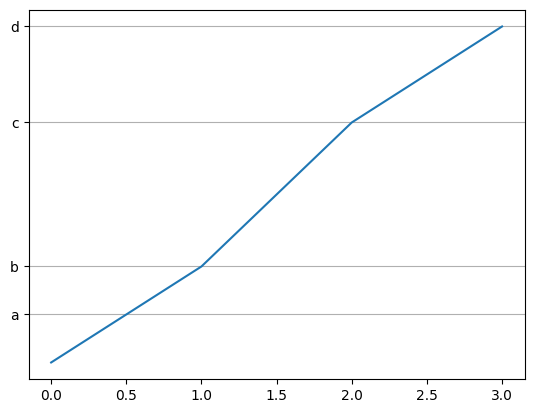

In [172]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([0,1,2,3])
y = np.array([0.655, 0.660, 0.675, 0.685])
my_xticks = ['a', 'b', 'c', 'd']
plt.yticks(y, my_xticks)
y = np.array([0.650, 0.660, 0.675, 0.685])
# plt.yticks(np.arange(y.min(), y.max(), 0.005))
plt.plot(x, y)
plt.grid(axis='y', linestyle='-')
plt.show()

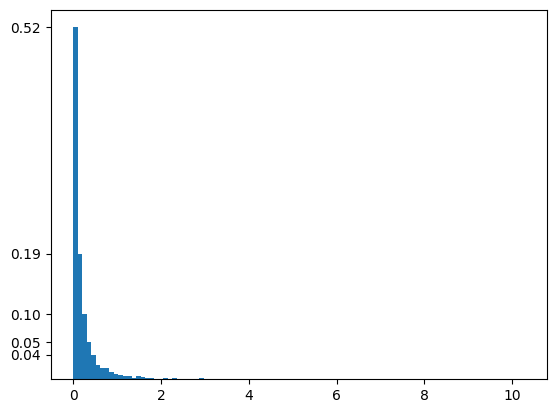

In [186]:
bins_cap, _, _ = plt.hist(rrts, bins=100)
# a.max()/len(rrts)
y_ticks =  [f"{bin_cap/len(rrts):0.2f}" for bin_cap in bins_cap]
plt.yticks(bins_cap[:5], y_ticks[:5])
pass


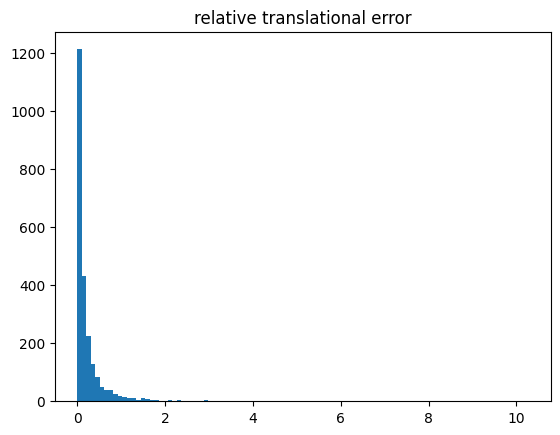

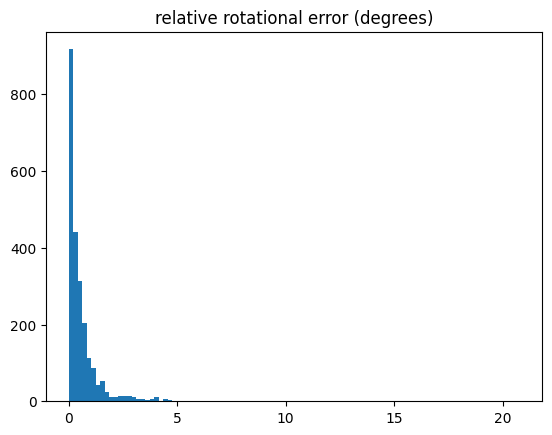

In [149]:
plt.hist(rrts, bins=100)
plt.title("relative translational error")
plt.show()
plt.hist(rres, bins=100)
plt.title("relative rotational error (degrees)")
plt.show()

In [41]:
matrix = pygicp.align_points(cp.astype("float64"), cpp.astype("float64"))
compute_registration_error(matrix, tr_mat)

(1.6020301705071074, 0.2929952388696535)

In [154]:
cpp_clone = np.copy(cpp+0)
cpp_clone[:,0] = 0
# cpp_clone[:,1] = 0
pcd_bboxes = o3d.geometry.PointCloud()
pcd_bboxes.points = o3d.utility.Vector3dVector(cpp)
pcd_bboxes.paint_uniform_color([0.1, 0.1, 0.7])
o3d.visualization.draw_geometries([pcd_bboxes])

In [160]:
from sklearn.cluster import KMeans
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cpp_clone[:,(0,2)])
ind = kmeans.predict(cpp_clone[:,(0,2)])

In [166]:
# number of points in each cluster
[(ind==i).sum() for i in range(n_clusters)]

[48, 38, 47, 14, 48, 51, 30, 35, 13, 8]

In [164]:
# visualize 1) full PC  2) PC without one cluster
pcs = []
for i in range(n_clusters):
    pcd_bboxes = o3d.geometry.PointCloud()
    if i == 0:
        continue
    pcd_bboxes.points = o3d.utility.Vector3dVector(cpp[ind==i])
    pcd_bboxes.paint_uniform_color([i/10, 0.5+i/20, 0.5+i/20])
    pcs.append(pcd_bboxes)
pcd_bboxes = o3d.geometry.PointCloud()
pcd_bboxes.points = o3d.utility.Vector3dVector(cpp+np.array([0,0,2.5]))
pcd_bboxes.paint_uniform_color([0.2, 0, 0])
pcs.append(pcd_bboxes)
o3d.visualization.draw_geometries(pcs)